In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as matplot
import itertools
import math

from tqdm import tqdm_notebook, tqdm
from os import listdir
from os.path import join
from ipywidgets import *

%matplotlib notebook

In [2]:
import sys
module_path = os.path.abspath(os.path.join('../python/python_src_preprocessing/src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import utils.writer.density as density

In [4]:
LOGGING = False

In [5]:
def log(*args):
    if LOGGING:
        print(*args)

def load_experiment(folder, key):
    files = list(filter(lambda file: key in file, listdir(folder)))
    
    frames = []
    for file in files:
        data = pd.read_csv(
            join(folder, file), 
            sep=' ', 
            names=['p-id', 'timestep', 'x', 'y', 'e'], 
            index_col=False, 
            header=None, 
            skiprows=0)
        
        data['x'] = data['x'] / 100
        data['y'] = data['y'] / 100
        
        frames.append((file, data))
        
    return frames
    
def load_multiple(path, folders, key):
    frames = []
    for folder in folders:
        frames.extend(load_experiment(join(path, folder), key))
            
    return frames

In [6]:
def plot_experiment(frame, title):
    fig, ax = matplot.subplots()
    ax.set_title(title)
    
    # map p-ids to targets
    for pId, group in frame.groupby('p-id'):
        ax.plot(group['x'], group['y'])
    
    ax.grid()

In [7]:
def extract_observation_area(frame, area):
    is_x = (frame['x'] >= area[0]) & (frame['x'] <= (area[0] + area[2]))
    is_y = (frame['y'] >= area[1]) & (frame['y'] <= (area[1] + area[3]))
    return frame[is_x & is_y]

In [8]:
def get_target_percentiles(pedestrians, ped2target, targets):
    if len(pedestrians)== 0:
        return None
    
    ids = list(pedestrians['p-id'])
    total = len(ids)
    
    filtered_dict = {k:v for k,v in ped2target.items() if k in ids}
    used_targets = filtered_dict.values()
    
    percentiles = {k:(len(list(v)) / total) for k, v in itertools.groupby(sorted(used_targets))}
    
    for k in targets:
        if k not in used_targets:
            percentiles[k] = 0.0
    
    return percentiles

In [38]:
def get_gaussian_grid(gauss_bound, resolution, sigma, ped_pos, radius):
    x = np.arange(-gauss_bound, gauss_bound + resolution, resolution) # gives gauss_bound_start:resolution:gauss_bound_stop
    
    xx, yy = np.meshgrid(x, x, sparse=False) # Make all grid points (based on resolution) in [gauss_bound_start, gauss_bound_stop] (2-dim-array)
        
    grid = np.square(xx-ped_pos[0]) + np.square(yy-ped_pos[1]) # distance to the origin of the observation area
    
    gauss = np.vectorize(gaussian_pdf)

    gauss_grid = gauss(sigma, grid, radius)
    
    return gauss_grid


def gaussian_pdf(sigma, x, radius ):
    zaehler = ((radius*2)**2)*np.sqrt(3)/2  # S_p
    nenner = (2*np.pi*sigma**2)

    normalization_factor = np.sqrt(zaehler/nenner)
    individual_density = normalization_factor * np.exp(-x / (2 * np.square(sigma)))

    return normalization_factor*individual_density


def add_pedestrian_to_field(ped, matrix, area, resolution, gauss_density_bound, sigma, radius, general_density_matrix):
    
    if general_density_matrix is None: # not None
        bool_individual_position = True
    else:
        bool_individual_position = False

    # calculate the density for one ped and add to matrix
    size = int(gauss_density_bound * 2 / resolution + 1)
    radius = int(size / 2) # equal to gauss_density_bound/resolution
    log('size', size, 'radius', radius)
    
    origin_x = area[0]
    origin_y = area[1]
    log('origin x', origin_x, 'origin y', origin_y)
    
    width = int(area[2] / resolution)
    height = int(area[3] / resolution)
    log('width', width, 'height', height)
    
    
    # necessary to map to center of the grid instead of the edge!
    offset = resolution / 2
    log('offset', offset)
    
    
    # find grid cell of pedestrian in observation area
    diff_x = int(np.round((ped['x'] - origin_x - offset) / resolution, 0))
    diff_y = int(np.round((ped['y'] - origin_y - offset) / resolution, 0))

    log('diff x', diff_x, 'diff y', diff_y)
    
    # area in which the pedestrian has an influence on the pedestrian density
    left_bound = int(max(0, diff_x - radius))
    right_bound = int(min(diff_x + radius, width - 1))
    upper_bound = int(min(diff_y + radius, height - 1))
    lower_bound = int(max(0, diff_y - radius))
    
    log('left', left_bound, 'right', right_bound)
    log('upper', upper_bound, 'lower', lower_bound)

    ## create density_field
    # position of pedestrian relative to center of grid cell
    grid_points_x = np.arange(origin_x+offset, origin_x + area[2] + resolution, resolution) # gives gauss_bound_start:resolution:gauss_bound_stop
    grid_points_y = np.arange(origin_y+offset, origin_y + area[3] + resolution, resolution)

    # center of cell in which the pedestrian is located
    grid_point_x = grid_points_x[diff_x]
    grid_point_y = grid_points_y[diff_y]

    ped_pos_rel_x = ped['x'] - grid_point_x
    ped_pos_rel_y = ped['y'] - grid_point_y

    # Position of pedestrian relative to cell center
    ped_pos_rel = np.array([ped_pos_rel_x, ped_pos_rel_y])

    log(bool_individual_position)
    
    if bool_individual_position:
        density_field = get_gaussian_grid(gauss_density_bound, resolution, sigma, ped_pos_rel, radius)
    else:
        density_field = general_density_matrix

    #print(np.max(density_field))
        
    # cutout of density field that is within the camera cutout
    left_bound_field = max(0, radius - diff_x)
    right_bound_field = left_bound_field + right_bound - left_bound

    lower_bound_field = max(0, radius - diff_y)
    upper_bound_field = lower_bound_field + upper_bound - lower_bound

    matrix[lower_bound:upper_bound+1, left_bound:right_bound+1] = \
        matrix[lower_bound:upper_bound+1, left_bound:right_bound+1] + density_field[lower_bound_field:upper_bound_field+1, left_bound_field:right_bound_field+1]

    # matrix = matrix / np.max(matrix)
    
    return matrix
    

def get_density_field(pedestrians, context):
    density_field = context.get('density_field', None)
    
    if density_field is not None:
        print(density_field)
    
    size = context.get('size', (0, 0))
    
    density_approx = np.zeros(size)
    ped_list = np.zeros([len(pedestrians),2])
    
    idx = 0
    for _, pedestrian in pedestrians.iterrows():
        density_approx = add_pedestrian_to_field(
            pedestrian, 
            density_approx, 
            context.get('area', None), 
            context.get('resolution', 1), 
            context.get('gauss_bounds', 10), 
            context.get('sigma', 0.7),
            context.get('pedestrian_radius', 0.4),
            density_field)

        ped_list[idx,:] = [pedestrian['x'], pedestrian['y']]
        idx += 1
        

    return density_approx

In [10]:
def process_percentiles(pedestrians, percentiles, density, context):
    data = context.get('percentiles', None)
    
    # create dataframe if not yet available
    if data is None:
        data = pd.DataFrame(columns=context.get('targets'))
    
    context['percentiles'] = data.append(percentiles, ignore_index=True)
    
    return context

def process_pedestrians(pedestrians, percentiles, density, context):
    data = context.get('pedestrians', None)
    
    # create dataframe if not yet available
    if data is None:
        data = []
    
    data.append(pedestrians)
    
    context['pedestrians'] = data
    
    return context
    
    
def process_peds_per_step(pedestrians, percentiles, density, context):
    data = context.get('pedestrians', None)
    
    # create dataframe if not yet available
    if data is None:
        data = pd.DataFrame(columns=['#peds'])
        
    context['pedestrians'] = data.append({'#peds': len(peds) }, ignore_index=True)
    
    return context
    
    
def process_densities(pedestrians, percentiles, density, context):
    data = context.get('densities', None)
    
    # create dataframe if not yet available
    if data is None:
        data = []
        context['densities'] = data
    
    distribution = [percentiles[key] for key in sorted(percentiles.keys())]
    data.append(np.concatenate((density.flatten(), distribution), axis=None))
    
    return context

    
def process_experiment(experiment, context):
    name = context.get('name', '')
    
    processors = context.get('processors', None)
    if processors is None or type(processors) != list:
        processors = []
    
    pId2Target = dict.fromkeys(list(frame['p-id'].unique()))
    
    # map p-ids to targets
    for pId, group in frame.groupby('p-id'):
        pId2Target[pId] = ('B' if group['x'].iloc[0] < 0 else 'A')
    
    if not context.get('exact', False):
        context['density_field'] = get_gaussian_grid(
            context.get('gauss_bounds', 0),
            context.get('resolution', 1),
            context.get('sigma', 1),
            [0, 0])
    
    area = context.get('area')
    resolution = context.get('resolution')
    
    size = (int(area[3]/ resolution), int(area[2] / resolution))
    context['size'] = size
    
    flag = True
    
    # extract #-of peds in observation area
    for timestep, trajectories in tqdm_notebook(frame.groupby('timestep'), desc=name, unit=' timestep'):
        pedestrians = extract_observation_area(trajectories, area)
        
        # skip if empty area
        if len(pedestrians) == 0:
            continue
            
        percentiles = get_target_percentiles(pedestrians, pId2Target, context.get('targets', ['A', 'B']))
        
        if percentiles['A'] == 0.5 and percentiles['B'] == 0.5:
            flag = not(flag)
            if flag:
                continue
            
        
        density = get_density_field(pedestrians, context)
        
        # execute processors
        for processor in processors:
            context = processor(pedestrians, percentiles, density, context)
        
        
    return context

In [11]:
input_path = 'juelich/KO/'
output_path = 'juelich/output/'
experiments = [
    'ko-240-050-240',
    'ko-240-060-240',
    'ko-240-080-240',
    'ko-240-100-240',
    'ko-240-120-240',
    'ko-240-150-240',
    'ko-240-240-240',
    'ko-300-050-300',
    'ko-300-080-300',
    'ko-300-120-300',
    'ko-300-150-300'
]

frames = load_multiple(input_path, experiments, 'combined')

In [56]:
results = []
for experiment, frame in tqdm_notebook(frames, desc='process files'):
    # plot_experiment(frame, experiment)
    context = dict({
        'name': experiment[:experiment.index('.')],
        'targets': ['A', 'B', 'C'],
        'area':  [-2.4, 3, 2.4, 1],
        'exact': True,
        'sigma': 0.7,
        'resolution': 0.1,
        'pedastrian_radius': 0.195,
        'gauss_bounds': 1,
        'processors': [
            process_percentiles,
            process_densities,
            process_pedestrians
        ]
    })
    context = process_experiment(frame, context)
    results.append(context)
    
    break
    
    
for result in tqdm_notebook(results, desc='saving density files'):
    name = result.get('name')
    densities = result.get('densities')
    
    with open(join(output_path, name + '.csv'), mode='w') as file:
        for density in densities:
            file.write(';'.join(map(lambda r: "{:.10f}".format(r), density)) + '\n')
        
        file.flush()

<IPython.core.display.Javascript object>


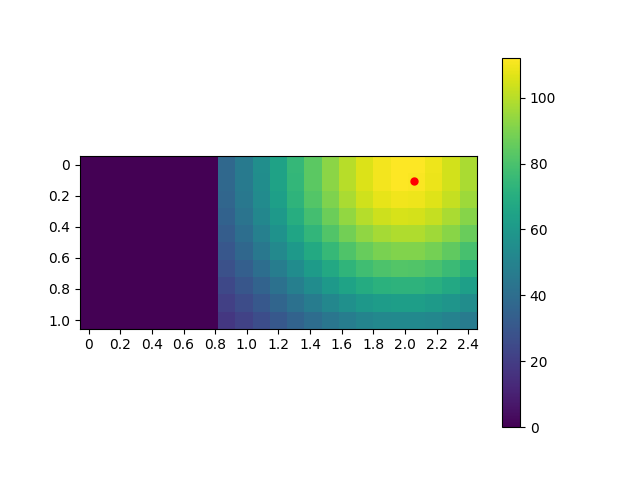

interactive(children=(IntSlider(value=477, description='frame', max=739), Output()), _dom_classes=('widget-int…

In [57]:
def extrac_xy(pedestrians, x0, y0, resolution):
    x = []
    y = []
    
    for _, ped in pedestrians.iterrows():
        x.append(abs(ped['x'] - x0) / resolution)
        y.append(abs(ped['y'] - y0) / resolution)
        
    return x, y
        

for result in tqdm_notebook(results, desc='process results'):
    name = result.get('name')
    densities = result.get('densities')
    area = context.get('area')
    peds = context.get('pedestrians')
    size = result.get('size')
    res = result.get('resolution')
    
    first = densities[477][:-3].reshape(size)
    #first = first / np.max(first)
    
    fig, ax = matplot.subplots()
    
    #img = ax.imshow(first, interpolation='Nearest')
    #cbar = fig.colorbar(img)
    
    #x, y = extrac_xy(peds[0], area[0], area[1], res)

    #pl = ax.plot(x, y, '.r', markersize=10)
    
    ax.set_xticks(np.linspace(0, len(first[0]) - 1, 13))
    ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
    
    ax.set_yticks(np.linspace(0, len(first) - 1, 6))
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    
    
    def update(frame):
        global cbar
        f = densities[frame][:-3].reshape(size)
        
        ax.clear()
        cbar.remove()
        
        img = ax.imshow(f, interpolation='Nearest')
        cbar = fig.colorbar(img)

        x, y = extrac_xy(peds[frame], area[0], area[1], res)
        ax.plot(x, y, '.r', markersize=10)

        ax.set_xticks(np.linspace(0, len(first[0]) - 1, 13))
        ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])

        ax.set_yticks(np.linspace(0, len(first) - 1, 6))
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        

    interact(update, frame=widgets.IntSlider(min=0, max=len(densities)-1, step=1, value=477));
    
    break
    
    

In [14]:
percentiles = pd.concat([result['percentiles'] for result in results])
display(percentiles.groupby(result.get('targets'), as_index=False).size().to_frame('frames').reset_index())

,A,B,C,frames
0,0.000000,1.000000,0.0,236
1,0.333333,0.666667,0.0,87
2,0.500000,0.500000,0.0,121
3,0.600000,0.400000,0.0,2
4,0.666667,0.333333,0.0,68
5,0.750000,0.250000,0.0,1
6,1.000000,0.000000,0.0,225


In [79]:
def gaussian(R, x, z):
    a = 1 / (2 * np.pi * (R**2))
    b = -1 / (2 * (R**2))
    
    return a * math.exp(b * (np.linalg.norm(np.array(x) - np.array(z))**2))

def density(pedestrians, z, R, g):
    S_p = g**2 * math.sqrt(3) / 2
    D_p = S_p * np.sum(list(map(lambda x: gaussian(R, x, z) ,pedestrians)))
    
    return D_p

<IPython.core.display.Javascript object>


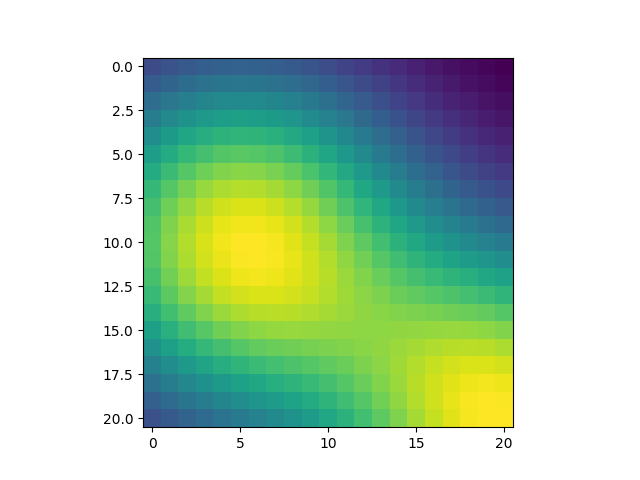

In [86]:
x = np.arange(-1, 1 + 0.1, 0.1)
xx, yy = np.meshgrid(x, x, sparse=False)

peds = [[1, 1], [-0.5, 0]]

matrix = np.zeros((len(x), len(x)))
for i in range(0, len(x)):
    for j in range(0, len(x)):
        matrix[i, j] = density(peds, [xx[i, j], yy[i, j]], 0.7, 0.195)
        
        
fig, ax = matplot.subplots()
ax.imshow(matrix)
        
